# 3D patch-based segmentation with U-Net

Code started from [Francesco's tutorials](https://github.com/FrancescoLR/tutorials)



## Imports

In [20]:
import os, sys, shutil, random, tempfile, glob, logging, math
from pathlib import Path

import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import SimpleITK as sitk

from monai.config import print_config
from monai.data import ArrayDataset, decollate_batch, DataLoader, CacheDataset, Dataset, PatchDataset, GridPatchDataset, PatchIter, PatchIterd
from monai.losses import DiceLoss
from monai.metrics import DiceMetric, MeanIoU, compute_meaniou
from monai.inferers import sliding_window_inference
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.transforms import (
    AsDiscrete,
    Compose,
    LoadImaged,
    EnsureChannelFirstd,
    Orientationd,
    Spacingd,
    ResizeWithPadOrCropd,
    RandCropByPosNegLabeld,
    Lambdad,
    ScaleIntensityd,
    RandSpatialCropSamples,
    CropForegroundd
)
from monai.utils import first

import ignite
import torch, torchvision

print_config()

MONAI version: 0.9.1rc3
Numpy version: 1.22.4
Pytorch version: 1.12.1+cu116
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 7a5de8b7b9db101a431e70ae2aa8ea7ebb8dfffe
MONAI __file__: /home/jaimebarranco/miniconda3/envs/3dmultilabel/lib/python3.9/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.9
Nibabel version: 4.0.1
scikit-image version: 0.19.3
Pillow version: 9.2.0
Tensorboard version: 2.9.1
gdown version: 4.5.1
TorchVision version: 0.13.1+cu116
tqdm version: 4.64.0
lmdb version: 1.3.0
psutil version: 5.9.1
pandas version: 1.4.3
einops version: 0.4.1
transformers version: 4.20.1
mlflow version: 1.27.0
pynrrd version: 0.4.3

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup 


### Paths and cuda check

In [9]:
main_dir = '/mnt/sda1/Repos/a-eye/a-eye_segmentation/3D_multilabel/'
data_dir = '/mnt/sda1/Repos/a-eye/a-eye_preprocessing/ANTs/' # train and val
test_data_dir = '/mnt/sda1/Repos/a-eye/Data'

[print(f"Data directory is: {data_dir}") if os.path.isdir(data_dir) else print("Check your data directory")]
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

print(torch.cuda.is_available())

Data directory is: /mnt/sda1/Repos/a-eye/a-eye_preprocessing/ANTs/
True


### Sets

In [10]:
num_total_subjects = 35 # total number of subjects
NUM_LABELS = 9 # number of different labels (without background)

# List of subjects taken for the template construction
template_subjects = ['sub-02','sub-03','sub-20','sub-29','sub-33'] # 5

# List of remaining subjects
all_subjects = list() # all the subjects (total)
for i in range(num_total_subjects):
    all_subjects.append('sub-'+str(i+1).zfill(2))

# Sets percentages
# 80-20(%) = 80-10-10 (%): 27, 4, 4 --> 22, 4, 4
# 70-30(%) = 70-15-15 (%): 25, 5, 5 --> 20, 5, 5
# 60-40(%) = 60-20-20 (%): 21, 7, 7 --> 16, 7, 7
OPTION = 1
if OPTION == 1:
    n_remaining_train = 22
    n_remaining_valid = n_remaining_test = 4
elif OPTION == 2:
    n_remaining_train = 20
    n_remaining_valid = n_remaining_test = 5
elif OPTION == 3:
    n_remaining_train = 16
    n_remaining_valid = n_remaining_test = 7

# Train
rem_subs_train = [elem for elem in all_subjects if elem not in template_subjects] # all the subjects except the 5 used to create the template (in registration)
rest_train = random.sample(rem_subs_train, n_remaining_train) # Remaining subjects out of the 5 for the template
train_subs = sorted(template_subjects + rest_train) # Training set subjects
print(f'{len(train_subs)}, {train_subs}')

# Valid
rem_subs_val = [sub for sub in all_subjects if sub not in train_subs] # Remaining subjects (all - training set)
val_subs = sorted(random.sample(rem_subs_val, n_remaining_valid))
print(f'{len(val_subs)}, {val_subs}')

# Test
rem_subs_test = [sub for sub in rem_subs_val if sub not in val_subs] # Remaining subjects (all - training set)
test_subs = sorted(rem_subs_test) # No random (take the remaining ones)
print(f'{len(test_subs)}, {test_subs}')

# Save test subjects (to inference)
list_test_file = main_dir + 'test_subjects.txt'
with open(list_test_file, 'w') as fp:
    for item in test_subs:
        fp.write("%s\n" % item) # write each item on a new line
    print('Saved test subjects to .txt for later inference')

27, ['sub-02', 'sub-03', 'sub-04', 'sub-06', 'sub-07', 'sub-08', 'sub-09', 'sub-10', 'sub-11', 'sub-12', 'sub-15', 'sub-16', 'sub-17', 'sub-18', 'sub-19', 'sub-20', 'sub-22', 'sub-23', 'sub-24', 'sub-27', 'sub-28', 'sub-29', 'sub-30', 'sub-31', 'sub-33', 'sub-34', 'sub-35']
4, ['sub-01', 'sub-13', 'sub-14', 'sub-32']
4, ['sub-05', 'sub-21', 'sub-25', 'sub-26']
Saved test subjects to .txt for later inference


#### Images and Labels paths

In [11]:
# Sets
train_images = []
train_labels = []
val_images = []
val_labels = []
test_images = []
test_labels = []

# Train set
for i in range(len(train_subs)):
    input_t1 = data_dir + 'a123/' + train_subs[i] + '/input/' + train_subs[i] + '_T1_cropped.nii.gz'
    input_labels = data_dir + 'a123/' + train_subs[i] + '/input/' + train_subs[i] + '_labels_cropped.nii.gz'
    train_images.append(input_t1)
    train_labels.append(input_labels)

# Train dictionary
data_train_dict = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images, train_labels)
]

# Validation set
for i in range(len(val_subs)):
    input_t1 = data_dir + 'a123/' + val_subs[i] + '/input/' + val_subs[i] + '_T1_cropped.nii.gz'
    input_labels = data_dir + 'a123/' + val_subs[i] + '/input/' + val_subs[i] + '_labels_cropped.nii.gz'
    val_images.append(input_t1)
    val_labels.append(input_labels)

# Validation dictionary
data_val_dict = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(val_images, val_labels)
]

# Test set
for i in range(len(test_subs)):
    input_t1 = data_dir + 'a123/' + test_subs[i] + '/input/' + test_subs[i] + '_T1_cropped.nii.gz'
    input_labels = data_dir + 'a123/' + test_subs[i] + '/input/' + test_subs[i] + '_labels_cropped.nii.gz'
    test_images.append(input_t1)
    test_labels.append(input_labels)

# Test dictionary
data_test_dict = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(test_images, test_labels)
]

num_train_samples = len(data_train_dict)
num_val_samples = len(data_val_dict)
num_test_samples = len(data_test_dict)
num_total_samples = num_train_samples + num_val_samples + num_test_samples
print(f"Train dataset is composed by {num_train_samples} subjects ({num_train_samples/num_total_samples*100:.2f}%), \
    \nvalidation set by {num_val_samples} subjects ({num_val_samples/num_total_samples*100:.2f}%), \
    \nand test set by {num_test_samples} subjects ({num_test_samples/num_total_samples*100:.2f}%).")

Train dataset is composed by 27 subjects (77.14%),     
validation set by 4 subjects (11.43%),     
and test set by 4 subjects (11.43%).


#### Min image size

In [12]:
''' 
Calculate the minimum and maximum axis of a set of images in a specific path
'''

# List of remaining subjects
all_subjects = list() # all the subjects (total)
for i in range(num_total_subjects):
    all_subjects.append('sub-'+str(i+1).zfill(2))

arr = [0, 0, 0] # [xmax, ymax, zmax]

for i in range(35):
    input_t1 = data_dir + 'a123/' + all_subjects[i] + '/input/' + all_subjects[i] + '_T1_cropped.nii.gz'
    n1 = nib.load(input_t1)
    if n1.shape[0] >= arr[0]:
        arr[0] = n1.shape[0]
    if n1.shape[1] >= arr[1]:
        arr[1] = n1.shape[1]
    if n1.shape[2] >= arr[2]:
        arr[2] = n1.shape[2]

print(f'(xmax, ymax, zmax) = ({arr[0]}, {arr[1]}, {arr[2]})')
min_axis = np.amax(arr)
min_axis = 96
print(f'min_axis = {min_axis}')

(xmax, ymax, zmax) = (79, 92, 80)
min_axis = 96


### Transforms
Several transforms to augment the dataset

In [13]:
# Function to crop the eye from the medical image
def masked(data_dict):
    eye_mask = (data_dict["label"] != 0)
    eye_mask[eye_mask == True] = 1
    eye_mask[eye_mask == False] = 0
    data_dict["image"] = data_dict["image"] * eye_mask

    return data_dict
# min_axis = 160
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]), #Load image file or files from provided path based on reader.
        Lambdad(keys=["image"], func=lambda image: torch.nan_to_num(image, nan=0)),
        EnsureChannelFirstd(keys=["image", "label"]), # ensures the original data to construct "channel first" shape
        ScaleIntensityd(keys=["image"]), # scale the intensity of input image to the given value range (minv, maxv). If minv and maxv and factor not provided, Normalize the data
        CropForegroundd(keys=["image", "label"], source_key="image"), # removes all zero borders to focus on the valid area of the images and labels
        Orientationd(keys=["image", "label"], axcodes="RAS"), # unifies the data orientation based on the affine matrix
        Spacingd(keys=["image", "label"], pixdim=(1, 1, 1), mode=("bilinear", "nearest")), # adjusts the spacing by pixdim based on the affine matrix
        ResizeWithPadOrCropd(keys=["image", "label"], spatial_size=(min_axis, min_axis, min_axis)), # (96, 96, 96)
        # masked,
        # RandCropByPosNegLabeld( # randomly crop patch samples from big image based on pos / neg ratio. The image centers of negative samples must be in valid body area
        #     keys=["image", "label"],
        #     label_key="label",
        #     spatial_size=(32, 32, 32),
        #     pos=1,
        #     neg=1,
        #     num_samples=4,
        #     image_key="image",
        #     image_threshold=0,
        # ),
    ]
)

val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        Lambdad(keys=["image"], func=lambda image: torch.nan_to_num(image, nan=0)),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityd(keys=["image"],),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(1, 1, 1), mode=("bilinear", "nearest")),
        ResizeWithPadOrCropd(keys=["image", "label"], spatial_size=(min_axis, min_axis, min_axis)), # (96, 96, 96)
        # masked,
        # RandCropByPosNegLabeld(
        #     keys=["image", "label"],
        #     label_key="label",
        #     spatial_size=(96, 96, 96),
        #     pos=1,
        #     neg=1,
        #     num_samples=1,
        #     image_key="image",
        #     image_threshold=0,
        # ),
    ]
)

#### Check transforms in DataLoader

image shape: (1, 1, 96, 96, 96), label shape: (1, 1, 96, 96, 96)
torch unique label: 10


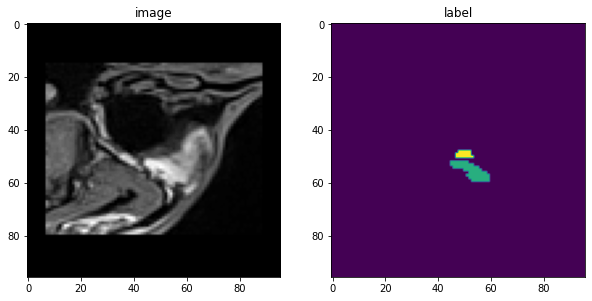

In [14]:
check_ds = Dataset(data=data_test_dict, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"], check_data["label"])
print(f"image shape: {image.shape}, label shape: {label.shape}")
print(f'torch unique label: {len(torch.unique(label))}')

plt.figure("check", (10,5))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[0, 0, :, :, 32], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[0, 0, :, :, 32])
plt.show()

# Save transformed image
# im_trans = sitk.GetImageFromArray(np.transpose(image[0].detach().cpu().numpy(), (3,2,1,0)))
# sitk.WriteImage(im_trans, main_dir+'im_trans.nii.gz')
# lab_trans = sitk.GetImageFromArray(np.transpose(label[0].detach().cpu().numpy(), (3,2,1,0)))
# sitk.WriteImage(lab_trans, main_dir+'lab_trans.nii.gz')

#### Save transformed images from loader set

In [344]:
'''
output_dir = main_dir+'Transformed_Test_Set/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Saving check_loader images
i = 1
for _, dict in enumerate(check_loader):
    # print(f"dict: {dict['image'].shape}")
    im_tensors = dict['image']
    lab_tensors = dict['label']
    # print(im_tensors[0].detach().cpu().numpy().shape)
    # print(lab_tensors[0].detach().cpu().numpy().shape)
    im_trans = sitk.GetImageFromArray(np.transpose(im_tensors[0].detach().cpu().numpy(), (3,2,1,0)))
    sitk.WriteImage(im_trans, output_dir+'im_trans'+str(i)+'.nii.gz')
    lab_trans = sitk.GetImageFromArray(np.transpose(lab_tensors[0].detach().cpu().numpy(), (3,2,1,0)))
    sitk.WriteImage(lab_trans, output_dir+'lab_trans'+str(i)+'.nii.gz')
    i += 1
    # if i == 1:
    #     break
# '''

### CacheDataset and DataLoader for training and validation
Here we use CacheDataset to accelerate training and val process, it's 10x faster than the regular Dataset.  
To achieve best performance, set `cache_rate=1.0` to cache all the data, if memory is not enough, set lower value.  
Users can also set `cache_num` instead of `cache_rate`, will use the minimum value of the 2 settings.  
And set `num_workers` to enable multi-threads during caching.  
If want to try the regular Dataset, just change to use the commented code below.

In [15]:
train_ds = CacheDataset(
    data=data_train_dict, transform=train_transforms,
    cache_rate=1.0, num_workers=8)
# train_ds = Dataset(data=train_files, transform=train_transforms)

# use batch_size=2 to load images and use RandCropByPosNegLabeld
# to generate 2 x 4 images for network training
train_loader = DataLoader(train_ds, batch_size=2, num_workers=8)

val_ds = CacheDataset(
    data=data_val_dict, transform=val_transforms, cache_rate=1.0, num_workers=8)
# val_ds = Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=8)

test_ds = CacheDataset(
    data=data_test_dict, transform=val_transforms, cache_rate=1.0, num_workers=8)
# val_ds = Dataset(data=val_files, transform=val_transforms)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False, num_workers=8)

Loading dataset: 100%|██████████| 4/4 [00:00<00:00, 31.09it/s]


#### Check transforms in DataLoader

image shape: (1, 1, 96, 96, 96), label shape: (1, 1, 96, 96, 96)
torch unique label: 10


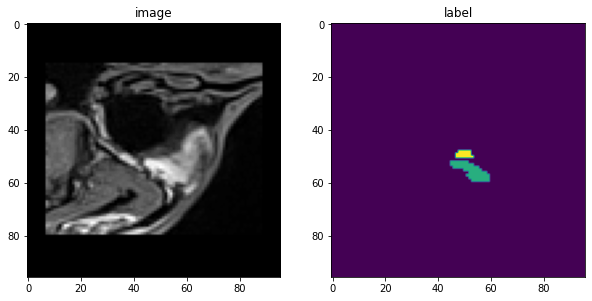

In [16]:
check_data = first(test_loader)
image, label = (check_data["image"], check_data["label"])
print(f"image shape: {image.shape}, label shape: {label.shape}")
print(f'torch unique label: {len(torch.unique(label))}')

plt.figure("check", (10,5))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[0, 0, :, :, 32], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[0, 0, :, :, 32])
plt.show()

# Save transformed image
# im_trans = sitk.GetImageFromArray(np.transpose(image[0].detach().cpu().numpy(), (3,2,1,0)))
# sitk.WriteImage(im_trans, main_dir+'im_trans.nii.gz')
# lab_trans = sitk.GetImageFromArray(np.transpose(label[0].detach().cpu().numpy(), (3,2,1,0)))
# sitk.WriteImage(lab_trans, main_dir+'lab_trans.nii.gz')

## Training

### Create Model, Loss, Optimizer

In [17]:
# Create UNet, DiceLoss and Adam optimizer
import gc 
gc.collect()
torch.cuda.empty_cache()
device = torch.device("cuda:0")
model = UNet(
    spatial_dims = 3,
    in_channels = 1,
    out_channels = NUM_LABELS+1,
    channels = (16, 32, 64, 128, 256),
    strides = (2, 2, 2, 2),
    num_res_units = 2,
    norm = Norm.BATCH,
    dropout = 0.5
).to(device)

loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)
dice_metric = DiceMetric(include_background=False, reduction="mean")

### Train 

In [21]:
FILE = "v2_cropped_images.pth"

max_epochs = 150
val_interval = 1
best_metric = -1
best_metric_epoch = -1

epoch_train_loss_values = []
epoch_val_loss_values = []
metric_values = []

post_pred = Compose([AsDiscrete(argmax=True, to_onehot=NUM_LABELS+1)])
post_label = Compose([AsDiscrete(to_onehot=NUM_LABELS+1)])

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )

        # Forward pass
        outputs = model(inputs)
        loss = loss_function(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        print(
            f"{step}/{math.ceil(len(train_ds) / train_loader.batch_size)}, "
            f"train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_train_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            step_val = 0
            epoch_val_loss = 0
            for val_data in val_loader:
                step_val += 1
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                roi_size = (min_axis, min_axis, min_axis)
                sw_batch_size = 4

                # Forward pass
                val_predictions = model(val_inputs)
                val_loss = loss_function(val_predictions, val_labels)
                epoch_val_loss += val_loss.item()

                # Inference
                val_outputs = sliding_window_inference(
                    val_inputs, roi_size, sw_batch_size, model)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)

            epoch_val_loss /= step_val
            epoch_val_loss_values.append(epoch_val_loss)
            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            # reset the status for next val round
            dice_metric.reset()

            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(
                    main_dir, FILE))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )

----------
epoch 1/150
1/14, train_loss: 0.9002
2/14, train_loss: 0.8991
3/14, train_loss: 0.8945
4/14, train_loss: 0.8875
5/14, train_loss: 0.8832
6/14, train_loss: 0.8856
7/14, train_loss: 0.8802
8/14, train_loss: 0.8774
9/14, train_loss: 0.8725
10/14, train_loss: 0.8749
11/14, train_loss: 0.8781
12/14, train_loss: 0.8673
13/14, train_loss: 0.8630
14/14, train_loss: 0.8635
epoch 1 average loss: 0.8805
saved new best metric model
current epoch: 1 current mean dice: 0.0432
best mean dice: 0.0432 at epoch: 1
----------
epoch 2/150
1/14, train_loss: 0.8541
2/14, train_loss: 0.8520
3/14, train_loss: 0.8499
4/14, train_loss: 0.8431
5/14, train_loss: 0.8397
6/14, train_loss: 0.8425
7/14, train_loss: 0.8421
8/14, train_loss: 0.8350
9/14, train_loss: 0.8315
10/14, train_loss: 0.8356
11/14, train_loss: 0.8382
12/14, train_loss: 0.8286
13/14, train_loss: 0.8322
14/14, train_loss: 0.8284
epoch 2 average loss: 0.8395
saved new best metric model
current epoch: 2 current mean dice: 0.0931
best mean

In [22]:
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")

train completed, best_metric: 0.8067 at epoch: 142


### Plot the loss and metric

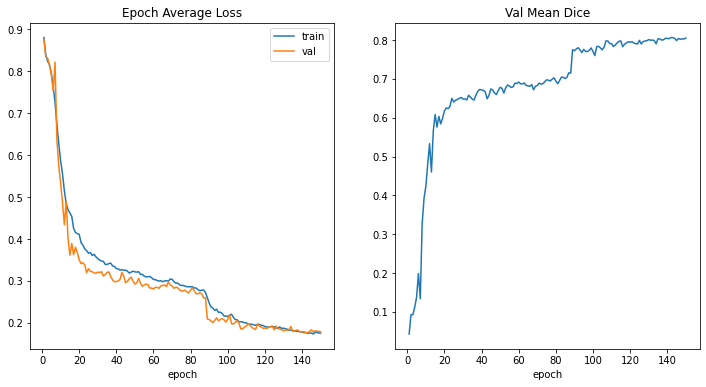

In [23]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_train_loss_values))]
plt.xlabel("epoch")
plt.plot(x, epoch_train_loss_values, label="train")
plt.plot(x, epoch_val_loss_values, label= "val")
plt.legend()
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

## Inference

In [ ]:
FILE = "v2_cropped_images.pth"

device = torch.device("cuda:0")
model = UNet(
    spatial_dims = 3,
    in_channels = 1,
    out_channels = NUM_LABELS+1,
    channels = (16, 32, 64, 128, 256),
    strides = (2, 2, 2, 2),
    num_res_units = 2,
    norm = Norm.BATCH,
    dropout = 0.5
).to(device)

model.load_state_dict(torch.load(
    os.path.join(main_dir, FILE)))

# IoU metric
post_pred = Compose([AsDiscrete(argmax=True, to_onehot=NUM_LABELS+1)])
post_label = Compose([AsDiscrete(to_onehot=NUM_LABELS+1)])
iou_metric = MeanIoU(include_background=False, reduction="mean")

model.eval()

with torch.no_grad():
    for i, test_data in enumerate(test_loader):
        test_inputs, test_labels = (
            test_data["image"].to(device),
            test_data["label"].to(device),
        )
        
        roi_size = (min_axis, min_axis, min_axis)
        sw_batch_size = 4

        test_outputs_pre = sliding_window_inference(
            test_inputs, roi_size, sw_batch_size, model
        )
        # print(test_outputs_pre)

        test_outputs = [post_pred(j) for j in decollate_batch(test_outputs_pre)]
        test_labels = [post_label(j) for j in decollate_batch(test_labels)]
        iou_metric(y_pred=test_outputs, y=test_labels)
        dice_metric(y_pred=test_outputs, y=test_labels)

        # plot the slice [:, :, 80]
        fig = plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(test_data["image"][0, 0, :, :, 32], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(test_data["label"][0, 0, :, :, 32])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.argmax(test_outputs_pre, dim=1).detach().cpu()[0, :, :, 32])
        # print(val_outputs.shape)
        im_result = sitk.GetImageFromArray(np.transpose(torch.argmax(test_outputs_pre, dim=1).detach().cpu().numpy(), (3,2,1,0)))
        if i == 0:
            sitk.WriteImage(im_result, main_dir+'result_'+str(i)+'.nii.gz')
        fig.suptitle('Test Monai A-Eye')
        # plt.show()
    
    # aggregate the final mean dice and IoU results
    dice_array = dice_metric.get_buffer()
    # print(dice_array.shape)
    # print(dice_array)
    test_metric_dice = dice_metric.aggregate().item()
    dice_metric.reset()
    iou_array = iou_metric.get_buffer() # (9, 10) --> 25 subjects and 10 classes
    # print(iou_array.shape)
    test_metric_iou = iou_metric.aggregate().item()
    iou_metric.reset()

    print(f"Total DSC is {test_metric_dice}. \nTotal IoU score is {test_metric_iou}.")
    
    # DSC per class
    dice_array_n = dice_array.transpose(0, 1) # to get in each line the DSC of each class
    dice_array_mean = []
    for i, val in enumerate(dice_array_n):
        dice_array_mean.append(torch.mean(val).item())
    print(f'Mean dice per class (test subjects): {dice_array_mean}')

    # IoU per class
    iou_array_n = iou_array.transpose(0, 1) # to get in each line the IoU of each class
    iou_array_mean = []
    for i, val in enumerate(iou_array_n):
        iou_array_mean.append(torch.mean(val).item())
    print(f'Mean IoU per class (test subjects): {iou_array_mean}')